In [9]:
import stable_baselines
from stable_baselines import DQN, A2C, ACER, ACKTR, PPO2
from stable_baselines.common.policies import MlpPolicy

from gameRL.game_simulators.blackjack_count import (
    BlackjackDeck,
    BlackjackCustomEnv,
    BlackjackDeckwithCount,
    BlackjackEnvwithRunningCount,
    BlackjackEnvwithTrueCount,
    BlackjackHandwithReshuffle
)
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [10]:
def get_model(model_path):
    model = None
    if "a2c" in model_path:
        model = A2C.load(model_path)
    elif "acer" in model_path:
        model = ACER.load(model_path)
    elif "acktr" in model_path:
        model = ACKTR.load(model_path)
    elif "ppo2" in model_path:
        model = PPO2.load(model_path)
    elif "dqn" in model_path:
        model = DQN.load(model_path)
    return model


def get_correct_env(var, num_decks, rho=1):
    if var == "basic":
        return BlackjackCustomEnv(num_decks)
    else:
        return BlackjackEnvwithRunningCount(num_decks, rho=rho)


def set_cur_state(
    env, dealer_hand, dummy_hand, player_hand=None, observing=False, count=None
):
    if not observing and not env.player:
        env.player = BlackjackHandwithReshuffle(env.blackjack_deck)
    env.dealer.hand = dealer_hand
    env.dummy.hand = dummy_hand
    if player_hand is not None:
        env.player.hand = player_hand
    env.observing = observing
    if count is not None:
        env.blackjack_deck.count = count
    return env

def set_basic_state(env, dealer_hand, player_hand):
    env.reset()
    env.dealer.hand = dealer_hand
    env.player.hand = player_hand
    return env
    

def get_policy_profile(model, obs, iters=1000):
    action_count = {0: 0, 1: 0, 2: 0, 3: 0, 4:0}
    for _ in range(iters):
        action, _states = model.predict(obs, deterministic=False)
        action_count[action] += 1
    print(action_count)
    return np.array(list(action_count.values())) / iters

def clean_up_strategy_profile(probs, observing):
    # 0: Stick, 1: Hit, 2: Join, 3: Observe, 4: Double Down
    if observing:
        probs[3] = np.sum(probs) - probs[2]
        probs[0] = 0
        probs[1] = 0
        probs[4] = 0
    else:
        probs[0] = probs[0] + probs[2]
        probs[2] = 0
    return probs



In [11]:
path = "/Users/max/Desktop/6.867/Final Project/gameRL/saved_models fixed/dqn_sum_21_rho_0.75_nd_10.zip"
env = get_correct_env("adv", 10, rho=0.75)
env.reset()
model = get_model(path)
print(model.sess)
env = set_cur_state(env, [3, 3], [2, 2], [2,4], False, count=15)
# env = set_basic_state(env, [3,3], [10,1])
obs = env._get_obs()
print("obs", obs)
counts = list(range(-5, 6))
dealer_hands = range(1, 11)
profs = []
observing = False
for count in counts:
# count = 0
# for i in dealer_hands:
    env = set_cur_state(env, [4, 10], [5, 3], [5,5], observing, count=count)
    obs = env._get_obs()
    print(obs)
    prof = model.action_probability(obs)
    clean = clean_up_strategy_profile(prof, observing)
    profs.append(prof)
arr = np.array(profs)
print(arr)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







obs (6, 3, False, 15, False)
(10, 4, False, -5, False)
(10, 4, False, -4, False)
(10, 4, False, -3, False)
(10, 4, False, -2, False)
(10, 4, False, -1, False)
(10, 4, False, 0, False)
(10, 4, False, 1, False)
(10, 4, False, 2, False)
(10, 4, False, 3, False)
(10, 4, False, 4, False)
(10, 4, False, 5, False)
[[0.19270849 0.24866503 0.         0.16101329 0.3976132 ]
 [0.19270849 0.24866503 0.         0.16101329 0.3976132 ]
 [0.19270849 0.24866503 0.         0.16101329 0.3976132 ]
 [0.19270849 0.24866503 0.         0.16101329 0.3976132 ]
 [0.19270849 0.24866503 0.         0.16101329 0.3976132 ]
 [0.14506444 0.3191309  0.         0.23953465 0.29626995]
 [0.24563265 0.36777377 0.         0.29854432 0.08804922]
 [0.1529307  0.28687817 0.         0.20931385

[Text(33.0, 0.5, 'Running Count')]

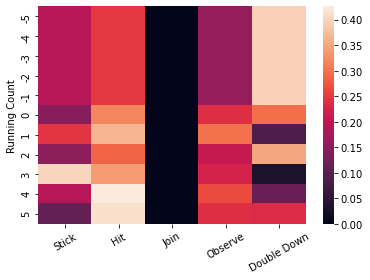

In [12]:
x_labels = ["Stick", "Hit", "Join", "Observe", "Double Down"]
g = sns.heatmap(arr, xticklabels=x_labels, yticklabels=counts)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set(ylabel='Running Count')